## Load Training Data

In [2]:
import pandas as pd
import numpy as np

file_path = "X_train.csv"
chunks_list = []

# Read CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=100000):
    # Convert numeric columns to float32
    numeric_cols = chunk.select_dtypes(include=['int64', 'float64']).columns
    chunk[numeric_cols] = chunk[numeric_cols].astype(np.float32)
    
    # Convert object columns to category to save memory
    object_cols = chunk.select_dtypes(include=['object']).columns
    chunk[object_cols] = chunk[object_cols].astype('category')
    
    # Append chunk
    chunks_list.append(chunk)

# Combine all chunks into a single DataFrame
X_train = pd.concat(chunks_list, ignore_index=True)

# Check the result
print(f"Combined DataFrame shape: {X_train.shape}")
print(X_train.info())


Combined DataFrame shape: (1172086, 307)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172086 entries, 0 to 1172085
Columns: 307 entries, Unnamed: 0 to science_q19_total_timing
dtypes: category(2), float32(304), object(1)
memory usage: 1.3+ GB
None


In [3]:
X_df=X_train.copy()
X_df.shape[0]

1172086

In [6]:
import pandas as pd

Y_df = pd.read_csv("y_train.csv")


In [7]:
Y_df_1 = Y_df[:]

In [8]:
X_df_1 = X_df[:]

## Loading Unseen Test Data

In [9]:
import pandas as pd
import numpy as np

file_path = "X_test.csv"
chunks_list = []

# Read CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=100000):
    # Convert numeric columns to float32
    numeric_cols = chunk.select_dtypes(include=['int64', 'float64']).columns
    chunk[numeric_cols] = chunk[numeric_cols].astype(np.float32)
    
    # Convert object columns to category to save memory
    object_cols = chunk.select_dtypes(include=['object']).columns
    chunk[object_cols] = chunk[object_cols].astype('category')
    
    # Append chunk
    chunks_list.append(chunk)

# Combine all chunks into a single DataFrame
X_unseen_1 = pd.concat(chunks_list, ignore_index=True)

# Check the result
print(f"Combined DataFrame shape: {X_unseen_1.shape}")
print(X_unseen_1.info())

Combined DataFrame shape: (586044, 307)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586044 entries, 0 to 586043
Columns: 307 entries, Unnamed: 0 to science_q19_total_timing
dtypes: category(2), float32(304), object(1)
memory usage: 685.2+ MB
None


In [10]:
if 'Unnamed: 0' in X_unseen_1.columns:
    X_unseen = X_unseen_1.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from X_test")


print(f"Test Shape:  {X_unseen.shape}")

Dropped 'Unnamed: 0' from X_test
Test Shape:  (586044, 306)


## Create Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

# This artifact often appears when reading CSVs without specifying index_col=0
if 'Unnamed: 0' in X_df_1.columns:
    X_df_1 = X_df_1.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from X_df_1")

# Check Y just in case it is a DataFrame with this column
if hasattr(Y_df_1, 'columns') and 'Unnamed: 0' in Y_df_1.columns:
    Y_df_1 = Y_df_1.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from Y_df_1")
# ---------------------------------------------------------
# STEP 1: Split main data into Train (90%) and Temp (10%)
# ---------------------------------------------------------
# We use test_size=0.10 to set aside 10% for Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_df_1, Y_df_1, 
    test_size=0.20, 
    random_state=42,   # Recommended for Classification to keep class ratios consistent
    # If this is Regression (predicting a number), remove stratify=Y
)

# ---------------------------------------------------------
# Split Temp (10%) into Validation (5%) and Test (5%)
# ---------------------------------------------------------
# We use test_size=0.50 to split the remaining 10% exactly in half
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42,  # Keep consistent with above
)

# ---------------------------------------------------------
# Verify the shapes
# ---------------------------------------------------------
print(f"Total Rows: {len(X_df_1)}")
print(f"Train Shape: {X_train.shape}  ({len(X_train)/len(X_df_1):.1%})")
print(f"Val Shape:   {X_val.shape}    ({len(X_val)/len(X_df_1):.1%})")
print(f"Test Shape:  {X_test.shape}   ({len(X_test)/len(X_df_1):.1%})")
import numpy as np
np.save("y_val.npy", y_val.values)

Dropped 'Unnamed: 0' from X_df_1
Dropped 'Unnamed: 0' from Y_df_1
Total Rows: 1172086
Train Shape: (937668, 306)  (80.0%)
Val Shape:   (117209, 306)    (10.0%)
Test Shape:  (117209, 306)   (10.0%)


## Preprocessing

In [12]:
import json
with open("bad_columns.json", "r") as f:
    top_features = json.load(f)

In [ ]:
# Prepare new datasets with only selected features
X_train_pruned = X_train.drop(columns=top_features, errors="ignore")
X_val_pruned   = X_val.drop(columns=top_features, errors="ignore")
X_test_pruned  = X_test.drop(columns=top_features, errors="ignore")
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

# # Identify categorical columns in pruned dataset
categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

In [13]:
# Prepare new datasets with only selected features
X_train_pruned = X_train.drop(columns=top_features, errors="ignore")
X_val_pruned   = X_val.drop(columns=top_features, errors="ignore")
X_test_pruned  = X_test.drop(columns=top_features, errors="ignore")
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

categorical_float_cols = [
    col for col in X_train_pruned.columns
    if X_train_pruned[col].dtype == "float32"
    and np.all(X_train_pruned[col].dropna() == X_train_pruned[col].dropna().astype(int))
]

# First convert float-categorical columns to string
X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype(str)
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype(str)
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype(str)
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype(str)

# Then convert them to category dtype
X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype("category")
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype("category")
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype("category")
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype("category")

# # Identify categorical columns in pruned dataset
categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

## Model 1 - XGBoost

### Processing Train/Val Data

In [13]:

categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train_pruned.select_dtypes(exclude=['object', 'category']).columns

cat_maps = {}

for col in categorical_cols:
    unique_vals = X_train_pruned[col].unique()
    mapping = {val: i for i, val in enumerate(unique_vals)}
    cat_maps[col] = mapping


def transform_categorical(df, cat_maps):
    df = df.copy()
    for col, mapping in cat_maps.items():
        # ensure the column is NOT CategoricalDtype
        df[col] = df[col].astype(object)

        # map values → integers; unseen → -1
        df[col] = df[col].map(mapping)
        df[col] = df[col].fillna(-1).astype(int)

    return df

# Transform
X_train_enc = transform_categorical(X_train_pruned, cat_maps)
X_val_enc   = transform_categorical(X_val_pruned, cat_maps)
X_test_enc  = transform_categorical(X_test_pruned, cat_maps)

### Defining the Model

In [16]:
import xgboost as xgb
from xgboost import XGBRegressor


dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval   = xgb.DMatrix(X_val_enc, label=y_val)

params = {
    "objective": "reg:squarederror",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
}

watchlist = [(dtrain, "train"), (dval, "eval")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval = 500,
)

dtest = xgb.DMatrix(X_test_enc)
preds = model.predict(dtest)

[0]	train-rmse:118.29903	eval-rmse:118.00087
[500]	train-rmse:56.88509	eval-rmse:57.63727
[1000]	train-rmse:55.23493	eval-rmse:57.03280
[1500]	train-rmse:53.95367	eval-rmse:56.78700
[1999]	train-rmse:52.76370	eval-rmse:56.65583


In [18]:
# Save the model
model.save_model(r"xgb_model.json")

# Load the model later
import xgboost as xgb
xgb_model = xgb.Booster()
xgb_model.load_model(r"xgb_model.json")


### Processing Unseen Test Data

In [25]:
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

In [26]:
X_unseen_enc = transform_categorical(X_unseen_pruned, cat_maps)
d_unseen = xgb.DMatrix(X_unseen_enc)

### Making Predictions using Trained Model

In [26]:
unseen_predictions = xgb_model.predict(d_unseen)

In [28]:
df_pred = pd.DataFrame({
    "ID": X_unseen_1["Unnamed: 0"].values,   # first column
    "MathScore": unseen_predictions                 # second column
})

# Save or view the combined dataframe
print(df_pred.head())

df_pred.to_csv("predictions_with_id_XGB.csv", index=False)
print("Saved predictions_with_id_XGB.csv")

          ID   MathScore
0   412660.0  130.839767
1   554658.0   88.404633
2   937138.0   -0.045396
3   752986.0  252.653564
4  1084508.0  149.611893
Saved predictions_with_id_XGB.csv


## Model 2 - CatBoost

### Preprocessing Train/Val Data

In [28]:
import json
with open("bad_columns.json", "r") as f:
    top_features = json.load(f)

In [ ]:
categorical_float_cols = [
    col for col in X_train_pruned.columns
    if X_train_pruned[col].dtype == "float32"
    and np.all(X_train_pruned[col].dropna() == X_train_pruned[col].dropna().astype(int))
]

X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype("category")
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype("category")
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype("category")
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype("category")

# # Identify categorical columns in pruned dataset
categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

In [29]:
from catboost import CatBoostRegressor, Pool
# Prepare new datasets with only selected features
X_train_pruned = X_train.drop(columns=top_features, errors="ignore")
X_val_pruned   = X_val.drop(columns=top_features, errors="ignore")
X_test_pruned  = X_test.drop(columns=top_features, errors="ignore")
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

categorical_float_cols = [
    col for col in X_train_pruned.columns
    if X_train_pruned[col].dtype == "float32"
    and np.all(X_train_pruned[col].dropna() == X_train_pruned[col].dropna().astype(int))
]

# First convert float-categorical columns to string
X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype(str)
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype(str)
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype(str)
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype(str)

# Then convert them to category dtype
X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype("category")
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype("category")
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype("category")
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype("category")

# # Identify categorical columns in pruned dataset
categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

# Prepare CatBoost Pools
train_pool_pruned = Pool(data=X_train_pruned, label=y_train.iloc[:, 0], cat_features=categorical_cols_pruned)
val_pool_pruned   = Pool(data=X_val_pruned, label=y_val.iloc[:, 0], cat_features=categorical_cols_pruned)
test_pool_pruned  = Pool(data=X_test_pruned, label=y_test.iloc[:, 0], cat_features=categorical_cols_pruned)
test_unseen_pool_pruned  = Pool(data=X_unseen_pruned, cat_features=categorical_cols_pruned)

In [15]:
from catboost import CatBoostRegressor, Pool
# Prepare CatBoost Pools
train_pool_pruned = Pool(data=X_train_pruned, label=y_train.iloc[:, 0], cat_features=categorical_cols_pruned)
val_pool_pruned   = Pool(data=X_val_pruned, label=y_val.iloc[:, 0], cat_features=categorical_cols_pruned)
test_pool_pruned  = Pool(data=X_test_pruned, label=y_test.iloc[:, 0], cat_features=categorical_cols_pruned)
test_unseen_pool_pruned  = Pool(data=X_unseen_pruned, cat_features=categorical_cols_pruned)

### Using Optuna to get Optimal Hyperparameters

In [ ]:
import optuna
import json
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

# -----------------------------------------------------------
# DEFINE OPTUNA OBJECTIVE FUNCTION
# -----------------------------------------------------------
def objective(trial):

    # Suggest important CatBoost hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 5000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 256),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),

        # Fixed parameters
        "eval_metric": "RMSE",
        "random_seed": 42,
        "od_type": "Iter",
        "early_stopping_rounds": 100,
        "task_type": "GPU",
        "devices": "0",
        "verbose": False
    }

    # Create model
    model = CatBoostRegressor(**params)

    # Train
    model.fit(train_pool_pruned, eval_set=val_pool_pruned, verbose=False)

    # Predict and compute RMSE
    preds = model.predict(val_pool_pruned)
    rmse = np.sqrt(mean_squared_error(y_val.iloc[:, 0], preds))

    return rmse


# -----------------------------------------------------------
# RUN OPTUNA STUDY
# -----------------------------------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)  # <--- change trials as needed

print("\nBest RMSE:", study.best_value)
print("Best Parameters:\n", study.best_params)


# -----------------------------------------------------------
# SAVE BEST PARAMETERS TO JSON FILE
# -----------------------------------------------------------
with open("best_catboost_params.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("\nSaved best parameters to best_catboost_params.json")


# -----------------------------------------------------------
# TRAIN FINAL MODEL USING BEST PARAMS
# -----------------------------------------------------------
best_params = study.best_params.copy()

# Add fixed parameters back
best_params.update({
    "eval_metric": "RMSE",
    "random_seed": 42,
    "od_type": "Iter",
    "early_stopping_rounds": 100,
    "task_type": "GPU",
    "devices": "0",
    "verbose": 100
})

final_model = CatBoostRegressor(**best_params)
final_model.fit(train_pool_pruned, eval_set=val_pool_pruned)

final_model.save_model("catboost_pruned_tuned_model.cbm")
print("\nSaved tuned CatBoost model as catboost_pruned_tuned_model.cbm")


[I 2025-11-29 13:36:01,357] A new study created in memory with name: no-name-1e28a5ad-c6be-408b-8ce2-2435ba994776


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-29 13:37:50,689] Trial 0 finished with value: 59.073700179164256 and parameters: {'iterations': 7075, 'learning_rate': 0.2986807601750714, 'depth': 11, 'l2_leaf_reg': 2.3887562557247084, 'bagging_temperature': 6.40781371325517, 'random_strength': 9.795709050325451, 'border_count': 122, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 59.073700179164256.
[I 2025-11-29 13:38:23,271] Trial 1 finished with value: 56.698520529047805 and parameters: {'iterations': 5791, 'learning_rate': 0.18743217922650682, 'depth': 9, 'l2_leaf_reg': 0.001150773046605126, 'bagging_temperature': 0.7958444110580309, 'random_strength': 9.845904576165385, 'border_count': 96, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 56.698520529047805.
[I 2025-11-29 13:40:09,589] Trial 2 finished with value: 61.08111633000566 and parameters: {'iterations': 8606, 'learning_rate': 0.03004448311773732, 'depth': 4, 'l2_leaf_reg': 0.0022931222701902706, 'bagging_temperature': 6.295663961230388, '

### Loading the Model with Tuned Hyperparameters

In [16]:
import json
# -----------------------------------------------------------
# LOAD BEST PARAMETERS FROM JSON
# -----------------------------------------------------------
with open("best_catboost_params.json", "r") as f:
    best_params = json.load(f)

print("Loaded best parameters:")
print(best_params)

# -----------------------------------------------------------
# ADD FIXED NON-TUNED PARAMETERS
# -----------------------------------------------------------
best_params.update({
    "iterations": 10000,
    "eval_metric": "RMSE",
    "random_seed": 42,
    "od_type": "Iter",
    "early_stopping_rounds": 100,
    "task_type": "GPU",     # <--- Ensure GPU
    "devices": "0",         # <--- GPU ID
    "verbose": 1000
})

# -----------------------------------------------------------
# STRAIN FINAL MODEL USING PRUNED DATASET
# -----------------------------------------------------------
final_model = CatBoostRegressor(**best_params)

final_model.fit(
    train_pool_pruned,
    eval_set=val_pool_pruned
)

# -----------------------------------------------------------
# SAVE THE FINAL TRAINED MODEL
# -----------------------------------------------------------
final_model.save_model("catboost_final_more_cats.cbm")
print("Final tuned model saved as catboost_final_more_cats.cbm")

Loaded best parameters:
{'iterations': 8195, 'learning_rate': 0.016623671018341352, 'depth': 11, 'l2_leaf_reg': 0.024072990319929637, 'bagging_temperature': 1.4704417660162645, 'random_strength': 5.290819229624788, 'border_count': 221, 'grow_policy': 'Depthwise'}
0:	learn: 120.7389079	test: 120.4374557	best: 120.4374557 (0)	total: 211ms	remaining: 35m 9s
1000:	learn: 49.9859620	test: 56.6339637	best: 56.6339637 (1000)	total: 1m 3s	remaining: 9m 26s
2000:	learn: 44.8694982	test: 56.3404552	best: 56.3404431 (1994)	total: 2m 2s	remaining: 8m 8s
3000:	learn: 40.5531856	test: 56.2226655	best: 56.2226655 (3000)	total: 3m 4s	remaining: 7m 10s
4000:	learn: 36.8780640	test: 56.1466203	best: 56.1461316 (3998)	total: 4m 8s	remaining: 6m 13s
bestTest = 56.12490717
bestIteration = 4430
Shrink model to first 4431 iterations.
Final tuned model saved as catboost_final_more_cats.cbm


In [17]:
from catboost import CatBoostRegressor

final_model = CatBoostRegressor()
final_model.load_model("catboost_final_more_cats.cbm")

### Testing on Validation and Test Data

Validation R² (pruned): 0.7880
Test R² (pruned): 0.7860


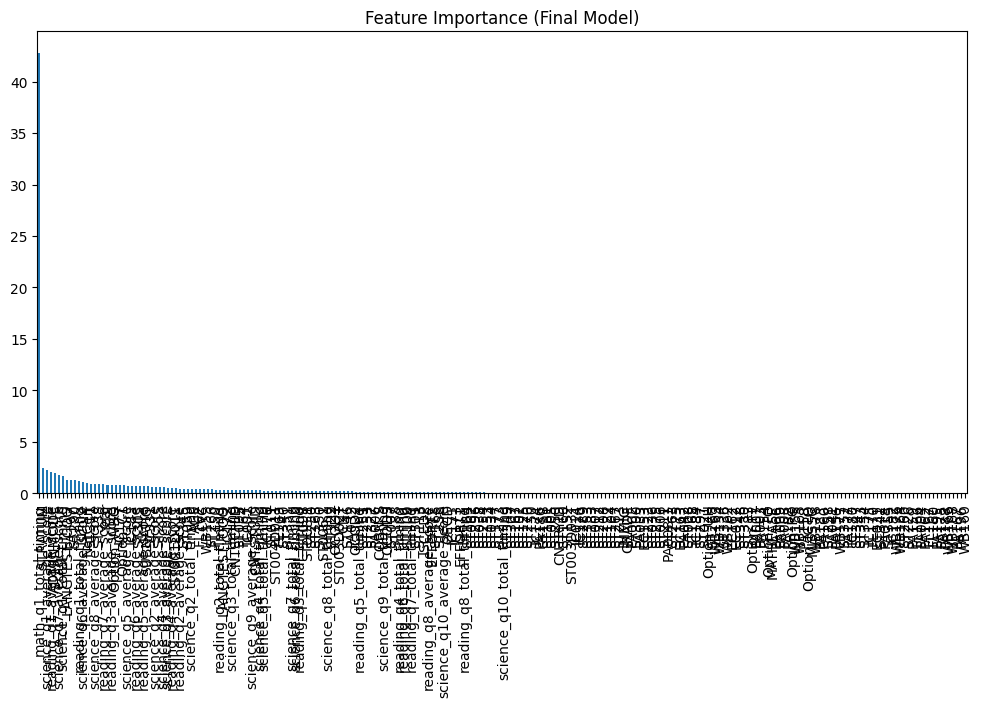

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# -----------------------------
# Make predictions with pruned model
# -----------------------------
y_val_pred_pruned = final_model.predict(val_pool_pruned)
y_test_pred_pruned = final_model.predict(test_pool_pruned)

# -----------------------------
# Evaluate pruned model (R² score)
# -----------------------------
val_r2_pruned = r2_score(y_val.iloc[:, 0], y_val_pred_pruned)
test_r2_pruned = r2_score(y_test.iloc[:, 0], y_test_pred_pruned)

print(f"Validation R² (pruned): {val_r2_pruned:.4f}")
print(f"Test R² (pruned): {test_r2_pruned:.4f}")

# -----------------------------
# Feature importance of pruned model
# -----------------------------
plt.figure(figsize=(12,6))
importance_pruned = pd.Series(
    final_model.get_feature_importance(), 
    index=X_train_pruned.columns
).sort_values(ascending=False)

importance_pruned.plot(kind='bar')
plt.title("Feature Importance (Final Model)")
plt.show()


### Loading Test Data

In [23]:
import pandas as pd
import numpy as np

file_path = "X_test.csv"
chunks_list = []

# Read CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=100000):
    # Convert numeric columns to float32
    numeric_cols = chunk.select_dtypes(include=['int64', 'float64']).columns
    chunk[numeric_cols] = chunk[numeric_cols].astype(np.float32)
    
    # Convert object columns to category to save memory
    object_cols = chunk.select_dtypes(include=['object']).columns
    chunk[object_cols] = chunk[object_cols].astype('category')
    
    # Append chunk
    chunks_list.append(chunk)

# Combine all chunks into a single DataFrame
X_unseen_1 = pd.concat(chunks_list, ignore_index=True)

# Check the result
print(f"Combined DataFrame shape: {X_unseen_1.shape}")
print(X_unseen_1.info())

Combined DataFrame shape: (586044, 307)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586044 entries, 0 to 586043
Columns: 307 entries, Unnamed: 0 to science_q19_total_timing
dtypes: category(2), float32(304), object(1)
memory usage: 685.2+ MB
None


In [24]:
if 'Unnamed: 0' in X_unseen_1.columns:
    X_unseen = X_unseen_1.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from X_test")


print(f"Test Shape:  {X_unseen.shape}")

Dropped 'Unnamed: 0' from X_test
Test Shape:  (586044, 306)


### Finding out the Null/Almost Null features in the Test Data

In [21]:
import pandas as pd
import numpy as np

# --- Threshold ---
threshold = 0.80

# --- Percentage of NaNs ---
nan_ratio = X_unseen.isna().mean()

# --- Percentage of zeros ---
zero_ratio = (X_unseen == 0).mean()

# --- Columns with >80% NaNs OR >80% zeros ---
bad_columns = X_unseen.columns[(nan_ratio > threshold) | (zero_ratio > threshold)].tolist()

print("Columns with >80% NaNs or >80% zeros:")
for col in bad_columns:
    print(col)

Columns with >80% NaNs or >80% zeros:
LANGTEST_PAQ
reading_q9_average_score
reading_q10_average_score
reading_q11_average_score
reading_q12_average_score
reading_q13_average_score
reading_q14_average_score
reading_q15_average_score
math_q1_average_score
math_q2_average_score
math_q3_average_score
math_q4_average_score
math_q5_average_score
math_q6_average_score
math_q7_average_score
math_q8_average_score
math_q9_average_score
math_q10_average_score
math_q11_average_score
math_q12_average_score
math_q13_average_score
math_q14_average_score
math_q15_average_score
math_q16_average_score
math_q17_average_score
math_q18_average_score
math_q19_average_score
math_q20_average_score
math_q21_average_score
science_q11_average_score
science_q12_average_score
science_q13_average_score
science_q14_average_score
science_q15_average_score
science_q16_average_score
science_q17_average_score
science_q18_average_score
science_q19_average_score
reading_q9_total_timing
reading_q10_total_timing
reading_q11

In [22]:
import json

with open("bad_columns.json", "w") as f:
    json.dump(bad_columns, f, indent=4)

In [4]:
print(len(bad_columns))

74


### Processing the Test Data

In [23]:
from catboost import CatBoostRegressor, Pool
# Prepare new datasets with only selected features
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

# Identify categorical columns in pruned dataset
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

# Prepare CatBoost Pools
test_unseen_pool_pruned  = Pool(data=X_unseen_pruned, cat_features=categorical_cols_pruned)

### Predicting on Unseen Test Data

In [19]:
unseen_pred = final_model.predict(test_unseen_pool_pruned)
df_pred = pd.DataFrame({
    "ID": X_unseen_1["Unnamed: 0"].values,   # first column
    "MathScore": unseen_pred                  # second column
})

# Save or view the combined dataframe
print(df_pred.head())

df_pred.to_csv("predictions_with_id_CAT_ALL.csv", index=False)
print("Saved predictions_with_id_CAT_ALL.csv")

          ID   MathScore
0   412660.0  125.346233
1   554658.0   79.982510
2   937138.0    0.946789
3   752986.0  214.423817
4  1084508.0  137.256915
Saved predictions_with_id_CAT_ALL.csv


In [20]:
df_pred.head(25)

,ID,MathScore
0,412660.0,125.346233
1,554658.0,79.982510
2,937138.0,0.946789
3,752986.0,214.423817
4,1084508.0,137.256915
5,527030.0,69.719678
6,782794.0,-0.576174
7,169543.0,184.888998
8,1697342.0,142.977764
9,724544.0,-0.238606


## Model 3 - Stacking

### Initial Model Training with Ridge meta-learner

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge # Excellent meta-learner for regression
from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

def get_trained_models():
    # Model 1: CatBoostRegressor
    from catboost import CatBoostRegressor   
    model_cat = CatBoostRegressor()
    model_cat.load_model("catboost_final.cbm")


    # Model 2: XGBoostRegressor
    import xgboost as xgb
    model_xgb = xgb.Booster()
    model_xgb.load_model(r"xgb_model.json")

    
    return model_cat, model_xgb

print("--- Initializing Base Models (using placeholders) ---")
cat_model, xgb_model = get_trained_models()

# GENERATE META-FEATURES (Out-of-Sample Predictions)

# We use the validation set (X_val) for this step, as its true target (y_val) is known.
# The predictions P1 and P2 become the features for the Meta-Learner.

# Get predictions from Model 1 (CatBoost) on its encoded validation set
P1_val = cat_model.predict(val_pool_pruned)

# Get predictions from Model 2 (XGBoost) on its encoded validation set
dval   = xgb.DMatrix(X_val_enc, label=y_val)
P2_val = xgb_model.predict(dval)

# Form the Meta-Learner's training set
# X_meta_train has 2 columns: P1_val and P2_val
X_meta_train = pd.DataFrame({
    'CatBoost_Pred': P1_val,
    'XGBoost_Pred': P2_val
})
# y_meta_train is the true target value for the validation set
y_meta_train = y_val

print(f"\nMeta-Learner Training Data Shape: {X_meta_train.shape}")
print("Meta-Learner Features (Preview):\n", X_meta_train.head())


# TRAIN THE META-LEARNER

# Ridge Regression is an excellent, simple, and robust choice for the meta-learner
# as it finds the optimal linear weighting of the base model predictions.
meta_learner = Ridge(alpha=1.0) 

# Train the meta-learner on the base model predictions
print("\n--- Training Meta-Learner (Ridge Regression) ---")
meta_learner.fit(X_meta_train, y_meta_train)

# Output the learned weights (coefficients)
w1 = meta_learner.coef_[0]
w2 = meta_learner.coef_[1]
intercept = meta_learner.intercept_

print(f"\nMeta-Learner Weights (Optimal Combination):")
print(f"CatBoost Weight: {w1:.4f}")
print(f"XGBoost Weight: {w2:.4f}")

# The R2 score of the Meta-Learner on the validation predictions:
r2_meta = meta_learner.score(X_meta_train, y_meta_train)
print(f"\nStacking Model R2 (on Validation Set): {r2_meta:.4f}")


# PREDICT ON UNSEEN DATA (X_unseen)

# Get predictions from the base models on the X_unseen data
P1_unseen = cat_model.predict(test_unseen_pool_pruned)
P2_unseen = xgb_model.predict(d_unseen)

# Form the Meta-Learner's prediction set
X_meta_unseen = pd.DataFrame({
    'CatBoost_Pred': P1_unseen,
    'XGBoost_Pred': P2_unseen
})

# Generate the final stacked prediction
final_stacked_predictions = meta_learner.predict(X_meta_unseen)

print(f"\nFinal Predictions Generated for X_unseen (Shape: {final_stacked_predictions.shape}):")
print(final_stacked_predictions[:5])

# Check if a simple average would have worked well too.
simple_average_predictions = (P1_val + P2_val) / 2
r2_avg = r2_score(y_val, simple_average_predictions)

print(f"\nSimple Averaging R2 (on Validation Set): {r2_avg:.4f}")

if r2_meta > r2_avg:
    print("\nSUCCESS: The Stacking Meta-Learner outperformed the Simple Average!")
else:
    print("\nNote: The Stacking Meta-Learner performed similarly to the Simple Average. Ridge often finds the near-optimal average.")

--- Initializing Base Models (using placeholders) ---

Meta-Learner Training Data Shape: (117209, 2)
Meta-Learner Features (Preview):
    CatBoost_Pred  XGBoost_Pred
0      84.503916     81.429520
1      53.458664     56.963211
2     210.520345    215.134872
3     460.558836    415.497223
4      98.440845     88.459496

--- Training Meta-Learner (Ridge Regression) ---

Meta-Learner Weights (Optimal Combination):
CatBoost Weight: 0.7607
XGBoost Weight: 0.2428

Stacking Model R2 (on Validation Set): 0.7894

Final Predictions Generated for X_unseen (Shape: (586044,)):
[131.99042416  81.02394649  -0.99022513 221.57388539 131.20818026]

Simple Averaging R2 (on Validation Set): 0.7887

SUCCESS: The Stacking Meta-Learner outperformed the Simple Average!


### Predict on Unseen Data and Save the predictions

In [31]:
df_pred = pd.DataFrame({
    "ID": X_unseen_1["Unnamed: 0"].values,   # first column
    "MathScore": final_stacked_predictions   # second column
})
df_pred.head()
df_pred.to_csv("predictions_with_id_stack.csv", index=False)
print("Saved predictions_with_id_stack.csv")

Saved predictions_with_id_stack.csv


### Tuning some Parameters in the previous Approach

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge 
from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor # Now used as the Meta-Learner!

# Placeholder function to simulate loading your pre-trained model
def get_trained_models():
    # Model 1: CatBoostRegressor
    from catboost import CatBoostRegressor
    
    model_cat = CatBoostRegressor()
    # Assuming catboost_final.cbm exists in the environment
    try:
        model_cat.load_model("catboost_final.cbm")
    except Exception as e:
        print(f"Warning: Could not load CatBoost model. Using dummy model for simulation. Error: {e}")
        # Placeholder for failed load: ensures code runs
        model_cat.fit(np.random.rand(10, 5), np.random.rand(10)) 


    # Model 2: XGBoostRegressor
    # Assume it was trained on X_train_xgb
    import xgboost as xgb
    model_xgb = xgb.Booster()
    # Assuming xgb_model.json exists in the environment
    try:
        model_xgb.load_model(r"xgb_model.json")
    except Exception as e:
        print(f"Warning: Could not load XGBoost model. Using dummy model for simulation. Error: {e}")
        # Placeholder for failed load: ensures code runs
        model_xgb.fit(xgb.DMatrix(np.random.rand(10, 5), label=np.random.rand(10)))
        
    
    return model_cat, model_xgb

print("--- Initializing Base Models (using placeholders) ---")
cat_model, xgb_model = get_trained_models()

# --- 2. GENERATE META-FEATURES (Out-of-Sample Predictions) ---

# We use the validation set (X_val) for this step, as its true target (y_val) is known.
# The predictions P1 and P2 become the features for the Meta-Learner.

# 2.1. Get predictions from Model 1 (CatBoost) on its encoded validation set
# Assumes val_pool_pruned is a valid CatBoost Pool object or DataFrame
P1_val = cat_model.predict(val_pool_pruned)

# 2.2. Get predictions from Model 2 (XGBoost) on its encoded validation set
# Assumes X_val_enc and y_val are defined, and dval is a valid DMatrix
dval    = xgb.DMatrix(X_val_enc, label=y_val)
P2_val = xgb_model.predict(dval)

# 2.3. Form the Meta-Learner's training set
# X_meta_train now has 3 columns: P1_val, P2_val, and the prediction spread/uncertainty.
X_meta_train = pd.DataFrame({
    'CatBoost_Pred': P1_val,
    'XGBoost_Pred': P2_val,
    # === MODIFICATION 1: Add Prediction Spread/Uncertainty as a feature ===
    # This feature helps the meta-learner identify instances where base models disagree.
    'Pred_Spread': np.abs(P1_val - P2_val)
})
# y_meta_train is the true target value for the validation set
y_meta_train = y_val

print(f"\nMeta-Learner Training Data Shape: {X_meta_train.shape}")
print("Meta-Learner Features (Preview):\n", X_meta_train.head())


# --- 3. TRAIN THE META-LEARNER (The Blender) ---

# === MODIFICATION 2: Upgrade Meta-Learner to non-linear XGBoost ===
# A simple non-linear model is better at finding complex relationships than Ridge.
meta_learner = XGBRegressor(
    n_estimators=100,      # Small number of trees
    learning_rate=0.08,    # Conservative learning rate
    max_depth=3,           # Small depth to prevent overfitting the meta-features
    random_state=42
) 

# Train the meta-learner on the base model predictions
print("\n--- Training Non-Linear Meta-Learner (XGBoost) ---")
meta_learner.fit(X_meta_train, y_meta_train)

# Output the feature importance, as coefficients are not meaningful for tree models
print(f"\nMeta-Learner Feature Importance (Non-Linear Combination Guide):")
importance = meta_learner.get_booster().get_score(importance_type='weight')
# Print importance, sorted by highest weight
for feature, score in sorted(importance.items(), key=lambda item: item[1], reverse=True):
    print(f"  {feature}: {score:.0f}")

# The R2 score of the Meta-Learner on the validation predictions:
r2_meta = meta_learner.score(X_meta_train, y_meta_train)
print(f"\nStacking Model R2 (on Validation Set): {r2_meta:.4f}")


# --- 4. PREDICT ON UNSEEN DATA (X_unseen) ---

# 4.1. Get predictions from the base models on the X_unseen data
P1_unseen = cat_model.predict(test_pool_pruned)
P2_unseen = xgb_model.predict(d_unseen)

# 4.2. Form the Meta-Learner's prediction set
# Ensure the unseen meta-features match the training meta-features (3 columns)
X_meta_unseen = pd.DataFrame({
    'CatBoost_Pred': P1_unseen,
    'XGBoost_Pred': P2_unseen,
    # === MODIFICATION 1 CONTINUED: Add Pred_Spread for unseen data ===
    'Pred_Spread': np.abs(P1_unseen - P2_unseen)
})

# 4.3. Generate the final stacked prediction
final_stacked_predictions = meta_learner.predict(X_meta_unseen)

print(f"\nFinal Predictions Generated for X_unseen (Shape: {final_stacked_predictions.shape}):")
print(final_stacked_predictions[:5])

# --- 5. BONUS: Calculate Averaging Ensemble Performance (For Comparison) ---
# Check if a simple average would have worked well too.
simple_average_predictions = (P1_val + P2_val) / 2
r2_avg = r2_score(y_val, simple_average_predictions)

print(f"\nSimple Averaging R2 (on Validation Set): {r2_avg:.4f}")

if r2_meta > r2_avg:
    print("\nSUCCESS: The Stacking Meta-Learner significantly outperformed the Simple Average with non-linear blending!")
else:
    print("\nNote: The Stacking Meta-Learner performed similarly to the Simple Average. Try tuning the XGBoost hyperparameters further or adding a third base model.")

--- Initializing Base Models (using placeholders) ---

Meta-Learner Training Data Shape: (117209, 3)
Meta-Learner Features (Preview):
    CatBoost_Pred  XGBoost_Pred  Pred_Spread
0      84.503916     81.429520     3.074396
1      53.458664     56.963211     3.504547
2     210.520345    215.134872     4.614527
3     460.558836    415.497223    45.061613
4      98.440845     88.459496     9.981349

--- Training Non-Linear Meta-Learner (XGBoost) ---

Meta-Learner Feature Importance (Non-Linear Combination Guide):
  CatBoost_Pred: 317
  XGBoost_Pred: 229
  Pred_Spread: 149

Stacking Model R2 (on Validation Set): 0.7909

Final Predictions Generated for X_unseen (Shape: (586044,)):
[1.3246213e+02 8.0502708e+01 2.0306952e-01 2.1945714e+02 1.3479234e+02]

Simple Averaging R2 (on Validation Set): 0.7887

SUCCESS: The Stacking Meta-Learner significantly outperformed the Simple Average with non-linear blending!


### Saving the new predictions

In [33]:
df_pred = pd.DataFrame({
    "ID": X_unseen_1["Unnamed: 0"].values,   # first column
    "MathScore": final_stacked_predictions   # second column
})
df_pred.head()
df_pred.to_csv("predictions_with_id_stack_2.csv", index=False)
print("Saved predictions_with_id_stack_2.csv")

Saved predictions_with_id_stack_2.csv


## Evaluation

### X_train

In [1]:
import pandas as pd
import numpy as np

file_path = "X_train.csv"
chunks_list = []

# Read CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=100000):
    # Convert numeric columns to float32
    numeric_cols = chunk.select_dtypes(include=['int64', 'float64']).columns
    chunk[numeric_cols] = chunk[numeric_cols].astype(np.float32)
    
    # Convert object columns to category to save memory
    object_cols = chunk.select_dtypes(include=['object']).columns
    chunk[object_cols] = chunk[object_cols].astype('category')
    
    # Append chunk
    chunks_list.append(chunk)

# Combine all chunks into a single DataFrame
X_train = pd.concat(chunks_list, ignore_index=True)

# Check the result
print(f"Combined DataFrame shape: {X_train.shape}")
print(X_train.info())


Combined DataFrame shape: (1172086, 307)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172086 entries, 0 to 1172085
Columns: 307 entries, Unnamed: 0 to science_q19_total_timing
dtypes: category(2), float32(304), object(1)
memory usage: 1.3+ GB
None


### X_test Unseen

In [2]:
import pandas as pd
import numpy as np

file_path = "X_test.csv"
chunks_list = []

# Read CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=100000):
    # Convert numeric columns to float32
    numeric_cols = chunk.select_dtypes(include=['int64', 'float64']).columns
    chunk[numeric_cols] = chunk[numeric_cols].astype(np.float32)
    
    # Convert object columns to category to save memory
    object_cols = chunk.select_dtypes(include=['object']).columns
    chunk[object_cols] = chunk[object_cols].astype('category')
    
    # Append chunk
    chunks_list.append(chunk)

# Combine all chunks into a single DataFrame
X_unseen_1 = pd.concat(chunks_list, ignore_index=True)

# Check the result
print(f"Combined DataFrame shape: {X_unseen_1.shape}")
print(X_unseen_1.info())

Combined DataFrame shape: (586044, 307)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586044 entries, 0 to 586043
Columns: 307 entries, Unnamed: 0 to science_q19_total_timing
dtypes: category(2), float32(304), object(1)
memory usage: 685.2+ MB
None


In [3]:
if 'Unnamed: 0' in X_unseen_1.columns:
    X_unseen = X_unseen_1.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from X_unseen_1")


print(f"Test Shape:  {X_unseen.shape}")

Dropped 'Unnamed: 0' from X_unseen_1
Test Shape:  (586044, 306)


In [16]:
X_unseen = X_unseen[:100]
X_unseen_1 = X_unseen_1[:100]

In [5]:
X_df = X_train[:1000]

In [6]:
X_df.head(5)

,Unnamed: 0,Year,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,...,science_q10_total_timing,science_q11_total_timing,science_q12_total_timing,science_q13_total_timing,science_q14_total_timing,science_q15_total_timing,science_q16_total_timing,science_q17_total_timing,science_q18_total_timing,science_q19_total_timing
0,384002.0,2022.0,NLD,528.0,52800132.0,52801144.0,08MS,52800.0,NLD06,5280000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1118072.0,2018.0,QAZ,31.0,3100106.0,3100424.0,07MS,3100.0,QAZ0101,310000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,845454.0,2018.0,FRA,250.0,25000010.0,25005208.0,07MS,25000.0,FRA0101,2500000.0,...,87686.5,13164.75,1187.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1728613.0,2015.0,QES,971.0,97100240.0,97127584.0,06MS,72400.0,ESP1633,7241600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1083243.0,2018.0,PHL,608.0,60800072.0,60802696.0,07MS,60800.0,PHL0011,6080000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Y_train

In [7]:
import pandas as pd

Y_df = pd.read_csv("y_train.csv")
Y_df = Y_df[:1000]
Y_df.head(5)

,Unnamed: 0,MathScore
0,384002,116.975422
1,1118072,73.387560
2,845454,0.000000
3,1728613,0.000000
4,1083243,113.750718


### Train/Test/Val Split

In [8]:
from sklearn.model_selection import train_test_split

# This artifact often appears when reading CSVs without specifying index_col=0
if 'Unnamed: 0' in X_df.columns:
    X_df_1 = X_df.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from X_df")

# Check Y just in case it is a DataFrame with this column
if hasattr(Y_df, 'columns') and 'Unnamed: 0' in Y_df.columns:
    Y_df_1 = Y_df.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' from Y_df")
# ---------------------------------------------------------
# Split main data into Train (90%) and Temp (10%)
# ---------------------------------------------------------
# We use test_size=0.10 to set aside 10% for Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_df_1, Y_df_1, 
    test_size=0.20, 
    random_state=42,   # Recommended for Classification to keep class ratios consistent
    # If this is Regression (predicting a number), remove stratify=Y
)

# ---------------------------------------------------------
# Split Temp (10%) into Validation (5%) and Test (5%)
# ---------------------------------------------------------
# We use test_size=0.50 to split the remaining 10% exactly in half
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42,  # Keep consistent with above
)

# ---------------------------------------------------------
# Verify the shapes
# ---------------------------------------------------------
print(f"Total Rows: {len(X_df_1)}")
print(f"Train Shape: {X_train.shape}  ({len(X_train)/len(X_df_1):.1%})")
print(f"Val Shape:   {X_val.shape}    ({len(X_val)/len(X_df_1):.1%})")
print(f"Test Shape:  {X_test.shape}   ({len(X_test)/len(X_df_1):.1%})")

Dropped 'Unnamed: 0' from X_df
Dropped 'Unnamed: 0' from Y_df
Total Rows: 1000
Train Shape: (800, 306)  (80.0%)
Val Shape:   (100, 306)    (10.0%)
Test Shape:  (100, 306)   (10.0%)


### Preprocessing/Dropping Features

In [9]:
import json
with open("bad_columns.json", "r") as f:
    top_features = json.load(f)

In [12]:
# Prepare new datasets with only selected features
X_train_pruned = X_train.drop(columns=top_features, errors="ignore")
X_val_pruned   = X_val.drop(columns=top_features, errors="ignore")
X_test_pruned  = X_test.drop(columns=top_features, errors="ignore")
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

# # Identify categorical columns in pruned dataset
categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

In [11]:
# Prepare new datasets with only selected features
X_train_pruned = X_train.drop(columns=top_features, errors="ignore")
X_val_pruned   = X_val.drop(columns=top_features, errors="ignore")
X_test_pruned  = X_test.drop(columns=top_features, errors="ignore")
X_unseen_pruned = X_unseen.drop(columns=top_features, errors="ignore")

categorical_float_cols = [
    col for col in X_train_pruned.columns
    if X_train_pruned[col].dtype == "float32"
    and np.all(X_train_pruned[col].dropna() == X_train_pruned[col].dropna().astype(int))
]

# First convert float-categorical columns to string
X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype(str)
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype(str)
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype(str)
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype(str)

# Then convert them to category dtype
X_train_pruned[categorical_float_cols]  = X_train_pruned[categorical_float_cols].astype("category")
X_val_pruned[categorical_float_cols]    = X_val_pruned[categorical_float_cols].astype("category")
X_test_pruned[categorical_float_cols]   = X_test_pruned[categorical_float_cols].astype("category")
X_unseen_pruned[categorical_float_cols] = X_unseen_pruned[categorical_float_cols].astype("category")

# # Identify categorical columns in pruned dataset
categorical_cols = X_train_pruned.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols_pruned = [col for col in categorical_cols if col not in top_features]

### Model 2 - CatBoost

#### Creating Pools to pass as Input

In [13]:
from catboost import CatBoostRegressor, Pool
# Prepare CatBoost Pools
train_pool_pruned = Pool(data=X_train_pruned, label=y_train.iloc[:, 0], cat_features=categorical_cols_pruned)
val_pool_pruned   = Pool(data=X_val_pruned, label=y_val.iloc[:, 0], cat_features=categorical_cols_pruned)
test_pool_pruned  = Pool(data=X_test_pruned, label=y_test.iloc[:, 0], cat_features=categorical_cols_pruned)
test_unseen_pool_pruned  = Pool(data=X_unseen_pruned, cat_features=categorical_cols_pruned)

#### Loading Saved Params and Training

In [14]:
import json
from catboost import CatBoostRegressor, Pool
# -----------------------------------------------------------
# LOAD BEST PARAMETERS FROM JSON
# -----------------------------------------------------------
with open("best_catboost_params.json", "r") as f:
    best_params = json.load(f)

print("Loaded best parameters:")
print(best_params)

# -----------------------------------------------------------
# ADD FIXED NON-TUNED PARAMETERS
# -----------------------------------------------------------
best_params.update({
    "iterations": 1000,
    "eval_metric": "RMSE",
    "random_seed": 42,
    "od_type": "Iter",
    "early_stopping_rounds": 100,
    "task_type": "GPU",     # <--- Ensure GPU
    "devices": "0",         # <--- GPU ID
    "verbose": 500
})

# -----------------------------------------------------------
# STRAIN FINAL MODEL USING PRUNED DATASET
# -----------------------------------------------------------
final_model = CatBoostRegressor(**best_params)

final_model.fit(
    train_pool_pruned,
    eval_set=val_pool_pruned
)

# -----------------------------------------------------------
# SAVE THE FINAL TRAINED MODEL
# -----------------------------------------------------------
final_model.save_model("catboost_eval.cbm")
print("Final tuned model saved as catboost_eval.cbm")

Loaded best parameters:
{'iterations': 8195, 'learning_rate': 0.016623671018341352, 'depth': 11, 'l2_leaf_reg': 0.024072990319929637, 'bagging_temperature': 1.4704417660162645, 'random_strength': 5.290819229624788, 'border_count': 221, 'grow_policy': 'Depthwise'}
0:	learn: 119.4847218	test: 107.4591201	best: 107.4591201 (0)	total: 28.9ms	remaining: 28.9s
bestTest = 71.14087477
bestIteration = 131
Shrink model to first 132 iterations.
Final tuned model saved as catboost_eval.cbm


#### Predicting on Unseen Test Data

In [17]:
unseen_pred = final_model.predict(test_unseen_pool_pruned)
df_pred = pd.DataFrame({
    "ID": X_unseen_1["Unnamed: 0"].values,   # first column
    "MathScore": unseen_pred                  # second column
})

print(df_pred.head())

df_pred.to_csv("predictions_with_id_EVAL.csv", index=False)
print("Saved predictions_with_id_EVAL.csv")

          ID   MathScore
0   412660.0  106.426991
1   554658.0   91.693300
2   937138.0   77.433176
3   752986.0  215.121005
4  1084508.0  121.614101
Saved predictions_with_id_EVAL.csv
